<a href="https://colab.research.google.com/github/divyeshag21/CICIDS2017/blob/main/CICIDS2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✔ Dataset Loaded Successfully!

   label_num  other_column
0          0             0
1          0             1
2          0             2
3          0             3
4          0             4

✔ 'label_num' detected and used as malware label!

label
1    2424095
0    2203723
Name: count, dtype: int64

✔ Model Training Completed! 🚀

============= MODEL PERFORMANCE (CICIDS) =============
Accuracy  : 0.9997396182219705
Precision : 0.9995045423801291
Recall    : 1.0
ROC-AUC   : 0.9999980900038893

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    439386
           1       1.00      1.00      1.00    486178

    accuracy                           1.00    925564
   macro avg       1.00      1.00      1.00    925564
weighted avg       1.00      1.00      1.00    925564



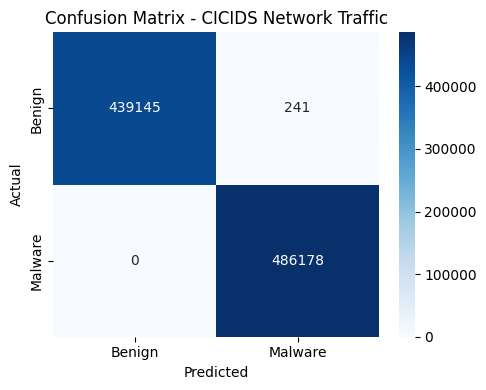

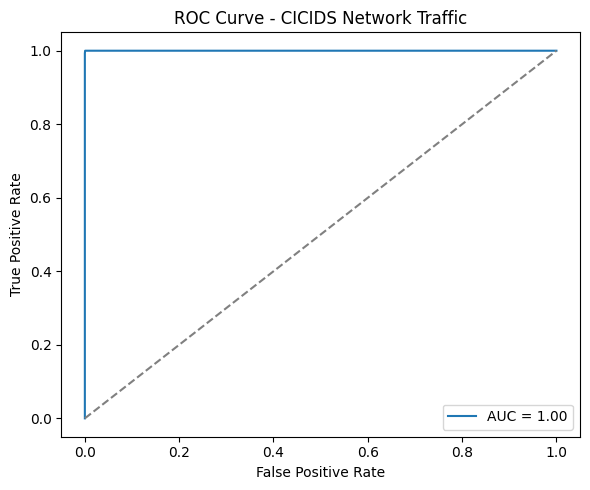

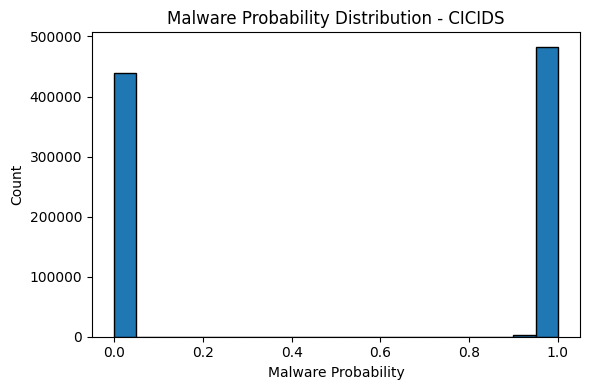

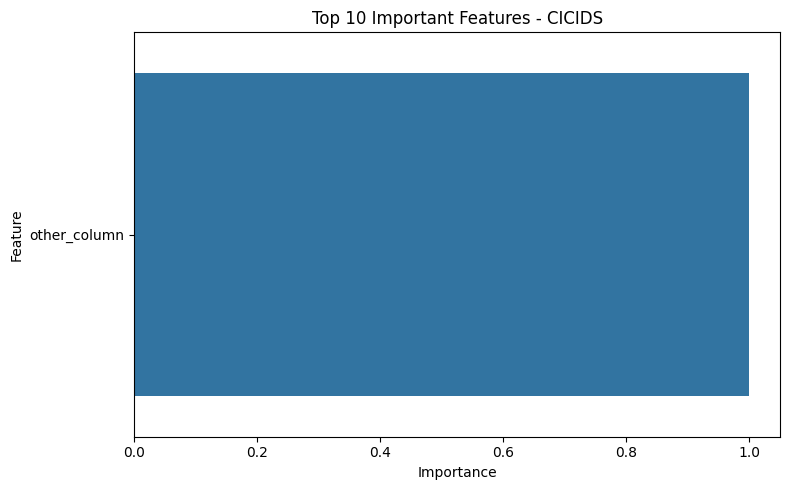


Top 10 Important Features:
         Feature  Importance
0  other_column         1.0

=== SAMPLE PREDICTION (CICIDS) ===
Prediction : Benign
Probability: 0.0


In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
)


df = pd.read_csv("CICIDS2017.csv")
df.columns = df.columns.str.strip()

print("✔ Dataset Loaded Successfully!\n")
print(df.head())



if "label_num" in df.columns:
    df["label"] = df["label_num"].astype(int)
    print("\n✔ 'label_num' detected and used as malware label!\n")
    print(df["label"].value_counts())
else:
    print("\n❌ ERROR: No 'label_num' found. Available columns:")
    print(df.columns.tolist())
    raise KeyError("❗ Please specify the correct label column from your dataset.")


X = df.drop(["label", "label_num"], axis=1, errors="ignore")
y = df["label"]

numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


model.fit(X_train, y_train)
print("\n✔ Model Training Completed! 🚀")


y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n============= MODEL PERFORMANCE (CICIDS) =============")
print("Accuracy  :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred))
print("Recall    :", recall_score(y_test, y_pred))
print("ROC-AUC   :", roc_auc_score(y_test, y_prob))
print("======================================================\n")

print("Classification Report:\n", classification_report(y_test, y_pred))


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malware"],
            yticklabels=["Benign","Malware"])
plt.title("Confusion Matrix - CICIDS Network Traffic")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("ROC Curve - CICIDS Network Traffic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Probability Histogram
plt.figure(figsize=(6,4))
plt.hist(y_prob, bins=20, edgecolor="black")
plt.title("Malware Probability Distribution - CICIDS")
plt.xlabel("Malware Probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


xgb = model.named_steps["classifier"]

if len(categorical_cols) > 0:
    ohe = model.named_steps["preprocess"].named_transformers_["cat"]
    encoded_cat = ohe.get_feature_names_out(categorical_cols)
    final_features = list(numeric_cols) + list(encoded_cat)
else:
    final_features = numeric_cols

imp = xgb.feature_importances_
feat_imp = pd.DataFrame({"Feature": final_features, "Importance": imp}).sort_values(
    by="Importance",
    ascending=False
)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(10))
plt.title("Top 10 Important Features - CICIDS")
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:\n", feat_imp.head(10))


sample = pd.DataFrame([X.iloc[0].to_dict()])
p = model.predict(sample)[0]
pr = model.predict_proba(sample)[0][1]

print("\n=== SAMPLE PREDICTION (CICIDS) ===")
print("Prediction :", "Malware" if p == 1 else "Benign")
print("Probability:", round(pr, 4))
print("==============================================")
